### Fit the old code to our dataset. 

纸上得来终觉浅，绝知此事要躬行。

In [1]:
options(warn=-1)
#import the package
library(randomForest)
library(pROC)
library(ROCR)

library(data.table)
library(xgboost)
library(caret)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var

Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

Loading required package: lattice
Loading required package: ggplot2

Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin



In [2]:
files_32 <- read.table("../org.eclipse.jdt.core_3.2/dataset-_3.2-filelevel.csv", header=T, sep=",")
files_34 <- read.table("../org.eclipse.jdt.core_3.4/dataset-_3.4-filelevel.csv", header=T, sep=",")
files_35 <- read.table("../org.eclipse.jdt.core_3.5/dataset-_3.5-filelevel.csv", header=T, sep=",")

nrow(files_32)
nrow(files_34)
nrow(files_35)

[1] 1112

[1] 1100

[1] 1094

### preprocess the dataframe to make it the same as example csv files. 

In [3]:
library(caret)
library(RANN)
data_preprocess <- function(dataset){
    subSet_that_dont_need_preProcess <- dataset[c("pre", "post")]
    hehe <- preProcess(dataset, method = c("range", "knnImpute")) 
    new_set <- predict(hehe, dataset)
    new_set[c("pre", "post")] <- subSet_that_dont_need_preProcess
    return (new_set)
}
files_32 <- data_preprocess(files_32)
files_34 <- data_preprocess(files_34)
files_35 <- data_preprocess(files_35)

In [4]:
files_32 = cbind(files_32[c("file")], files_32[c("pre", "post")], files_32[,1:18], files_32[,22:26])
# files_32 <- na.omit(files_32)

files_34 = cbind(files_34[c("file")], files_34[c("pre", "post")], files_34[,1:18], files_34[,22:26])
# files_34 <- na.omit(files_34)

files_35 = cbind(files_35[c("file")], files_35[c("pre", "post")], files_35[,1:18], files_35[,22:26])
# files_35 <- na.omit(files_35)

In [5]:
files_32$buggy = files_32$post > 0
files_34$buggy = files_34$post > 0
files_35$buggy = files_35$post > 0


In [6]:
head(files_32)

file,pre,post,NOT,NOI,TLOC,ACD,NSM,NSF,NOM,...,VG_total,VG_max,FOUT_total,FOUT_max,MLOC_avg,NBD_avg,PAR_avg,VG_avg,FOUT_avg,buggy
eclipse\org.eclipse.jdt.core\compiler\org\eclipse\jdt\internal\compiler\lookup\MethodVerifier.java,1,0,1,0,0.0671290238,0,0.0000000,0.000000000,0.079136691,...,0.0951048951,0.053462940,0.102824041,0.06993007,0.065067419,0.3806818,0.20718816,0.106542056,0.22949495,FALSE
eclipse\org.eclipse.jdt.core\model\org\eclipse\jdt\core\IClassFile.java,0,0,0,1,0.0010468464,0,0.0000000,0.000000000,0.016786571,...,0.0032634033,0.001215067,0.000000000,0.00000000,0.000000000,0.0000000,0.15946844,0.000000000,0.00000000,FALSE
eclipse\org.eclipse.jdt.core\search\org\eclipse\jdt\core\search\TypeNameRequestor.java,0,0,1,0,0.0002617116,0,0.0000000,0.000000000,0.002398082,...,0.0004662005,0.001215067,0.000000000,0.00000000,0.005174036,0.1875000,0.69767442,0.000000000,0.00000000,FALSE
eclipse\org.eclipse.jdt.core\compiler\org\eclipse\jdt\internal\compiler\flow\InsideSubRoutineFlowContext.java,0,0,1,0,0.0041873855,0,0.0000000,0.000000000,0.014388489,...,0.0041958042,0.004860267,0.005068791,0.01398601,0.018971464,0.2500000,0.06976744,0.010280374,0.06222222,FALSE
eclipse\org.eclipse.jdt.core\model\org\eclipse\jdt\internal\core\RenameElementsOperation.java,0,0,1,0,0.0047108087,0,0.0000000,0.000000000,0.011990408,...,0.0065268065,0.008505468,0.005792904,0.01748252,0.019661336,0.1875000,0.13953488,0.037009346,0.08533333,FALSE
eclipse\org.eclipse.jdt.core\dom\org\eclipse\jdt\core\dom\ThisExpression.java,0,0,1,0,0.0088981942,0,0.0078125,0.006430868,0.028776978,...,0.0074592075,0.003645200,0.014482259,0.02097902,0.018540295,0.2343750,0.12790698,0.006853583,0.08888889,FALSE


In [7]:
# col_name <- names(files_32)
# env_vars <- col_name
# for (env in env_vars){
#    print(paste(env, "+"))
# }
# env_vars

### Logistic Regression

In [11]:
test_classification <- function (label, train, test) 
{
    cat("-------------------", label, "-------------------\n")
    model.glm <- glm((post>0) ~ 
                    NOT +
                    NOI +
                    TLOC +
                    ACD +
                    NSM +
                    NSF +
                    NOM +
                    NOF +
                    MLOC_total +
                    MLOC_max +
                    NBD_total +
                    NBD_max +
                    PAR_total +
                    PAR_max +
                    VG_total +
                    VG_max +
                    FOUT_total +
                    FOUT_max +
                    pre +
                    MLOC_avg +
                    NBD_avg +
                    PAR_avg +
                    VG_avg +
                    FOUT_avg
                    , data=train, family = "binomial")
    test.prob <- predict(model.glm, test, type="response")
    test.pred <- test.prob>=0.50

    outcome <- table(factor(test$post>0, levels=c(F,T)), factor(test.pred, levels=c(F,T)))
    TN <- outcome[1,1]
    FN <- outcome[2,1]
    FP <- outcome[1,2]
    TP <- outcome[2,2]
    precision <- if (TP + FP ==0) { 1 } else { TP / (TP + FP) }
    recall <- TP / (TP + FN)
    accuracy <- (TP + TN) / (TN + FN + FP + TP)
    defects <- (TP + FN) / (TN + FN + FP + TP)
    cat("defects, precision, recall, accuracy \n")
    return (c(defects, precision, recall, accuracy))
}

cat("Logistic regression classification fileLevel. \nx.y means that trained on x, predict on y\n\n")
test_classification(2.2, files_32, files_32)
test_classification(2.4, files_32, files_34)
test_classification(2.5, files_32, files_35)

test_classification(4.2,files_34, files_32)
test_classification(4.4,files_34, files_34)
test_classification(4.5,files_34, files_35)

test_classification(5.2,files_35, files_32)
test_classification(5.3,files_35, files_34)
test_classification(5.4,files_35, files_35)

Logistic regression classification fileLevel. 
x.y means that trained on x, predict on y

------------------- 2.2 -------------------
defects, precision, recall, accuracy 


[1] 0.1250000 0.6315789 0.1726619 0.8839928

------------------- 2.4 -------------------
defects, precision, recall, accuracy 


[1] 0.1363636 0.6486486 0.1600000 0.8736364

------------------- 2.5 -------------------
defects, precision, recall, accuracy 


[1] 0.0786106 0.3939394 0.1511628 0.9149909

------------------- 4.2 -------------------
defects, precision, recall, accuracy 


[1] 0.1250000 0.2868852 0.2517986 0.8282374

------------------- 4.4 -------------------
defects, precision, recall, accuracy 


[1] 0.1363636 0.7260274 0.3533333 0.8936364

------------------- 4.5 -------------------
defects, precision, recall, accuracy 


[1] 0.0786106 0.2596154 0.3139535 0.8756856

------------------- 5.2 -------------------
defects, precision, recall, accuracy 


[1] 0.12500000 0.57142857 0.08633094 0.87769784

------------------- 5.3 -------------------
defects, precision, recall, accuracy 


[1] 0.1363636 0.7083333 0.1133333 0.8727273

------------------- 5.4 -------------------
defects, precision, recall, accuracy 


[1] 0.0786106 0.8125000 0.1511628 0.9305302

Recall is low. Which means there are still a lot of the buggy file are not identified.

But the precision are generally higher than `0.6`, it means when this model say "this file is defect-prone", this decision is most likely to be true. 

### Random Forest

In [9]:
# Perform training:
test_classification <- function (label, train, testSet, graph_name) {
    cat("---------------", label, "-------------------", "\n")
    rf_classifier2 = randomForest(as.factor(buggy) ~

                                                NOT +
                                                NOI +
                                                TLOC +
                                                ACD +
                                                NSM +
                                                NSF +
                                                NOM +
                                                NOF +
                                                MLOC_total +
                                                MLOC_max +
                                                NBD_total +
                                                NBD_max +
                                                PAR_total +
                                                PAR_max +
                                                VG_total +
                                                VG_max +
                                                FOUT_total +
                                                FOUT_max +
                                                pre +
                                                MLOC_avg +
                                                NBD_avg +
                                                PAR_avg +
                                                VG_avg +
                                                FOUT_avg

                                  , data=train, ntree=100, mtry=2, importance=TRUE)
    # because of the as.factor(...), randomforest can fit a classification model. 
#     print(rf_classifier2$confusion)
    
    TN <- rf_classifier2$confusion[1,1]
    FN <- rf_classifier2$confusion[2,1]
    FP <- rf_classifier2$confusion[1,2]
    TP <- rf_classifier2$confusion[2,2]
    precision <- if (TP + FP ==0) { 1 } else { TP / (TP + FP) }
    recall <- TP / (TP + FN)
    accuracy <- (TP + TN) / (TN + FN + FP + TP)
    defects <- (TP + FN) / (TN + FN + FP + TP)
    
    # print(importance(rf_classifier2))
    pdf(file=graph_name, width = 11, height = 8.5)
    varImpPlot(rf_classifier2, main = label)
    dev.off()

    rf_p_train <- predict(rf_classifier2, type="prob", newdata = testSet)[,2]
    rf_pr_train <- prediction(rf_p_train, testSet$buggy)
    r_auc_train <- performance(rf_pr_train, measure = "auc")@y.values[[1]] 
#     print(r_auc_train)
#     cat("--------------------------------------\n\n\n\n")
    cat("defects, precision, recall, accuracy, auc \n")
    return (c(defects, precision, recall, accuracy, r_auc_train))
}

cat("Random Forest classification fileLevel. \nx.y means that trained on x, predict on y\n\n")
test_classification(2.2, files_32, files_32, "RF_2.2_fileLevel.pdf")
test_classification(2.4, files_32, files_34, "RF_2.4_fileLevel.pdf")
test_classification(2.5, files_32, files_35, "RF_2.5_fileLevel.pdf")

test_classification(4.2, files_34, files_32, "RF_4.2_fileLevel.pdf")
test_classification(4.4, files_34, files_34, "RF_4.4_fileLevel.pdf")
test_classification(4.5, files_34, files_35, "RF_4.5_fileLevel.pdf")

test_classification(5.2, files_35, files_32, "RF_5.2_fileLevel.pdf")
test_classification(5.4, files_35, files_34, "RF_5.4_fileLevel.pdf")
test_classification(5.5, files_35, files_35, "RF_5.5_fileLevel.pdf")

Random Forest classification fileLevel. 
x.y means that trained on x, predict on y

--------------- 2.2 ------------------- 
defects, precision, recall, accuracy, auc 


[1] 0.1250000 0.6000000 0.1510791 0.8812950 0.9983179

--------------- 2.4 ------------------- 
defects, precision, recall, accuracy, auc 


[1] 0.1250000 0.6176471 0.1510791 0.8821942 0.8010947

--------------- 2.5 ------------------- 
defects, precision, recall, accuracy, auc 


[1] 0.1250000 0.5121951 0.1510791 0.8758993 0.8067553

--------------- 4.2 ------------------- 
defects, precision, recall, accuracy, auc 


[1] 0.1363636 0.6708861 0.3533333 0.8881818 0.7931414

--------------- 4.4 ------------------- 
defects, precision, recall, accuracy, auc 


[1] 0.1363636 0.6629213 0.3933333 0.8900000 0.9999825

--------------- 4.5 ------------------- 
defects, precision, recall, accuracy, auc 


[1] 0.1363636 0.6543210 0.3533333 0.8863636 0.7890538

--------------- 5.2 ------------------- 
defects, precision, recall, accuracy, auc 


[1] 0.07861060 0.61538462 0.09302326 0.92413163 0.77782871

--------------- 5.4 ------------------- 
defects, precision, recall, accuracy, auc 


[1] 0.0786106 0.4090909 0.1046512 0.9177331 0.7756175

--------------- 5.5 ------------------- 
defects, precision, recall, accuracy, auc 


[1] 0.07861060 0.35294118 0.06976744 0.91681901 0.99097914

### XGBoost

In [10]:
test_classification_xgb <- function (label, train, test, graph_name) {
    cat("---------------", label, "-------------------", "\n")
    
    setDT(train)
    setDT(test)
    
    labels <- train$buggy
    ts_label <- test$buggy
    new_tr <- model.matrix(~.+0,data = train[,-c("buggy", "post", "file"),with=F])
    new_ts <- model.matrix(~.+0,data = test[,-c("buggy", "post", "file"),with=F])
    labels <- as.numeric(labels) #-1
    ts_label <- as.numeric(ts_label) #-1
    dtrain <- xgb.DMatrix(data = new_tr, label = labels)
    dtest <- xgb.DMatrix(data = new_ts,label=ts_label)

    params <- list(
            booster = "gbtree",
            objective = "binary:logistic",
            eta=0.3,
            gamma=0,
            max_depth=6,
            min_child_weight=1,
            subsample=1,
            colsample_bytree=1
    )

#     xgbcv <- xgb.cv(params = params
#                     ,data = dtrain
#                     ,nrounds = 1000
#                     ,nfold = 5
#                     ,showsd = T
#                     ,stratified = T
#                     ,print.every.n = 10
#                     ,early.stop.round = 20
#                     ,maximize = F
#     )

    xgb1 <- xgb.train(
               params = params
              ,data = dtrain
              ,nrounds = 57
              ,watchlist = list(val=dtest,train=dtrain)
              ,print.every.n = 10
              ,early.stop.round = 10
              ,maximize = F
              ,eval_metric = "error"
                ,verbose = 0
    )

    xgbpred <- predict(xgb1,dtest)
    xgbpred <- ifelse(xgbpred > 0.5,1,0)
    xgbpred[xgbpred == 1] <- TRUE
    
    cm <- confusionMatrix(factor(xgbpred), factor(ts_label))
#     print(cm$table)
    
    TN <- as.numeric(cm$table[1])
    FN <- as.numeric(cm$table[3])
    FP <- as.numeric(cm$table[2])
    TP <- as.numeric(cm$table[4])
    precision <- if (TP + FP ==0) { 1 } else { TP / (TP + FP) }
    recall <- TP / (TP + FN)
    accuracy <- (TP + TN) / (TN + FN + FP + TP)
    defects <- (TP + FN) / (TN + FN + FP + TP)

    pdf(file=graph_name, width = 11, height = 8.5)
    mat <- xgb.importance(feature_names = colnames(new_tr),model = xgb1)
    xgb.plot.importance(importance_matrix = mat[1:20]) #first 20 variables
    dev.off()
    
    cat("defects, precision, recall, accuracy \n")
    return (c(defects, precision, recall, accuracy))
}

cat("XGBoost classification fileLevel \nx.y means that trained on x, predict on y\n\n")
test_classification_xgb(2.2, files_32, files_32, "XGB_2.2_fileLevel.pdf")
test_classification_xgb(2.4, files_32, files_34, "XGB_2.4_fileLevel.pdf")
test_classification_xgb(2.5, files_32, files_35, "XGB_2.5_fileLevel.pdf")

test_classification_xgb(4.2, files_34, files_32, "XGB_4.2_fileLevel.pdf")
test_classification_xgb(4.4, files_34, files_34, "XGB_4.4_fileLevel.pdf")
test_classification_xgb(4.5, files_34, files_35, "XGB_4.5_fileLevel.pdf")

test_classification_xgb(5.2, files_35, files_32, "XGB_5.2_fileLevel.pdf")
test_classification_xgb(5.4, files_35, files_34, "XGB_5.4_fileLevel.pdf")
test_classification_xgb(5.5, files_35, files_35, "XGB_5.5_fileLevel.pdf")

XGBoost classification fileLevel 
x.y means that trained on x, predict on y

--------------- 2.2 ------------------- 
defects, precision, recall, accuracy 


[1] 0.1250000 1.0000000 0.9928058 0.9991007

--------------- 2.4 ------------------- 
defects, precision, recall, accuracy 


[1] 0.1363636 0.4285714 0.3800000 0.8463636

--------------- 2.5 ------------------- 
defects, precision, recall, accuracy 


[1] 0.0786106 0.2975207 0.4186047 0.8765996

--------------- 4.2 ------------------- 
defects, precision, recall, accuracy 


[1] 0.1250000 0.3875000 0.4460432 0.8426259

--------------- 4.4 ------------------- 
defects, precision, recall, accuracy 


[1] 0.1363636 1.0000000 0.9933333 0.9990909

--------------- 4.5 ------------------- 
defects, precision, recall, accuracy 


[1] 0.0786106 0.2402597 0.4302326 0.8482633

--------------- 5.2 ------------------- 
defects, precision, recall, accuracy 


[1] 0.1250000 0.4523810 0.2733813 0.8678058

--------------- 5.4 ------------------- 
defects, precision, recall, accuracy 


[1] 0.1363636 0.4415584 0.2266667 0.8554545

--------------- 5.5 ------------------- 
defects, precision, recall, accuracy 


[1] 0.0786106 1.0000000 0.9883721 0.9990859

------------------------------------

[1] "file"       "pre"        "post"       "NOT"        "NOI"       
 [6] "TLOC"       "ACD"        "NSM"        "NSF"        "NOM"       
[11] "NOF"        "MLOC_total" "MLOC_max"   "NBD_total"  "NBD_max"   
[16] "PAR_total"  "PAR_max"    "VG_total"   "VG_max"     "FOUT_total"
[21] "FOUT_max"   "MLOC_avg"   "NBD_avg"    "PAR_avg"    "VG_avg"    
[26] "FOUT_avg"   "buggy"

[1] "file"       "pre"        "post"       "NOT"        "NOI"       
 [6] "TLOC"       "ACD"        "NSM"        "NSF"        "NOM"       
[11] "NOF"        "MLOC_total" "MLOC_max"   "NBD_total"  "NBD_max"   
[16] "PAR_total"  "PAR_max"    "VG_total"   "VG_max"     "FOUT_total"
[21] "FOUT_max"   "MLOC_avg"   "NBD_avg"    "PAR_avg"    "VG_avg"    
[26] "FOUT_avg"   "buggy"

Warning message:
"'print.every.n' is deprecated.
Use 'print_every_n' instead.
See help("Deprecated") and help("xgboost-deprecated")."Warning message:
"'early.stop.round' is deprecated.
Use 'early_stopping_rounds' instead.
See help("Deprecated") and help("xgboost-deprecated")."

[1]	train-error:0.080377+0.006523	test-error:0.149976+0.023357 
Multiple eval metrics are present. Will use test_error for early stopping.
Will train until test_error hasn't improved in 20 rounds.

[11]	train-error:0.041701+0.005741	test-error:0.135062+0.021756 
[21]	train-error:0.016078+0.002895	test-error:0.133231+0.024041 
Stopping. Best iteration:
[4]	train-error:0.057078+0.006252	test-error:0.127585+0.027410



Warning message:
"'print.every.n' is deprecated.
Use 'print_every_n' instead.
See help("Deprecated") and help("xgboost-deprecated")."Warning message:
"'early.stop.round' is deprecated.
Use 'early_stopping_rounds' instead.
See help("Deprecated") and help("xgboost-deprecated")."

[1]	val-error:0.128181	train-error:0.076421 
Multiple eval metrics are present. Will use train_error for early stopping.
Will train until train_error hasn't improved in 10 rounds.

[11]	val-error:0.129123	train-error:0.046598 
[21]	val-error:0.139491	train-error:0.019571 
[31]	val-error:0.147031	train-error:0.008388 
[41]	val-error:0.151744	train-error:0.003728 
[51]	val-error:0.150801	train-error:0.001864 
[57]	val-error:0.150801	train-error:0.001864 


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 843  89
         1  70  59
                                          
               Accuracy : 0.8501          
                 95% CI : (0.8272, 0.8711)
    No Information Rate : 0.8605          
    P-Value [Acc > NIR] : 0.8459          
                                          
                  Kappa : 0.3403          
 Mcnemar's Test P-Value : 0.1534          
                                          
            Sensitivity : 0.9233          
            Specificity : 0.3986          
         Pos Pred Value : 0.9045          
         Neg Pred Value : 0.4574          
             Prevalence : 0.8605          
         Detection Rate : 0.7945          
   Detection Prevalence : 0.8784          
      Balanced Accuracy : 0.6610          
                                          
       'Positive' Class : 0               
                                          

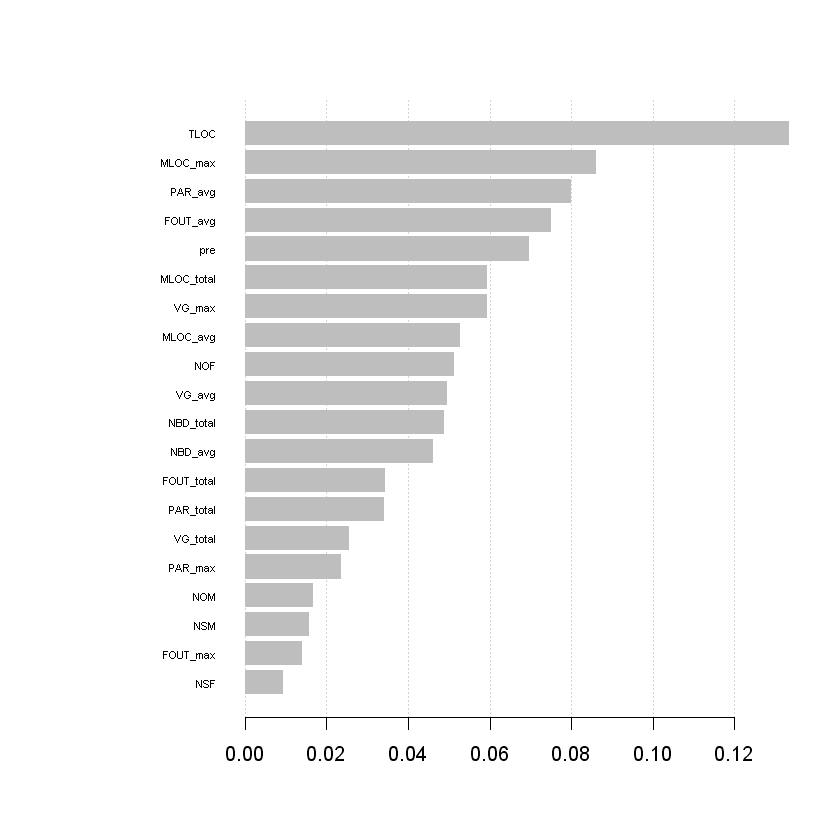

In [19]:
train <- files_32
test <- files_34

names(train)
names(test)

labels <- train$buggy
ts_label <- test$buggy

new_tr <- model.matrix(~.+0, data = train[,-c("buggy", "post", "file"),with=F])
new_ts <- model.matrix(~.+0, data = test[,-c("buggy", "post", "file"),with=F])

labels <- as.numeric(labels) #-1
ts_label <- as.numeric(ts_label) #-1

dtrain <- xgb.DMatrix(data = new_tr, label=labels)
dtest <- xgb.DMatrix(data = new_ts, label=ts_label)

# length(dtrain)

# length(dtest)

params <- list(
        booster = "gbtree",
        objective = "binary:logistic",
        eta=0.3,
        gamma=0,
        max_depth=6,
        min_child_weight=1,
        subsample=1,
        colsample_bytree=1
)

# xgbcv <- xgb.cv(params = params
#                 ,data = dtrain
#                 ,nrounds = 1000
#                 ,nfold = 5
#                 ,showsd = T
#                 ,stratified = T
#                 ,print.every.n = 10
#                 ,early.stop.round = 20
#                 ,maximize = F
# )

xgb1 <- xgb.train(
           params = params
          ,data = dtrain
          ,nrounds = 57
          ,watchlist = list(val=dtest,train=dtrain)
          ,print.every.n = 10
          ,early.stop.round = 10
          ,maximize = F
          ,eval_metric = "error"
)

xgbpred <- predict(xgb1,dtest)
xgbpred <- ifelse(xgbpred > 0.5,1,0)

xgbpred[xgbpred == 1] <- TRUE

library(caret)
confusionMatrix(factor(xgbpred), factor(ts_label))

mat <- xgb.importance(feature_names = colnames(new_tr),model = xgb1)
xgb.plot.importance(importance_matrix = mat[1:20]) #first 20 variables

In [67]:
head(train)

"files_32[, 19]",pre,post,NOT,NOI,TLOC,ACD,NSM,NSF,NOM,...,VG_total,VG_max,FOUT_total,FOUT_max,MLOC_avg,NBD_avg,PAR_avg,VG_avg,FOUT_avg,buggy
eclipse\org.eclipse.jdt.core\compiler\org\eclipse\jdt\internal\compiler\lookup\MethodVerifier.java,1,0,1,0,516,0,0,0,33,...,204,44,142,20,13.575758,1.0303030,1.4848485,6.181818,4.303030,FALSE
eclipse\org.eclipse.jdt.core\model\org\eclipse\jdt\core\IClassFile.java,0,0,0,1,11,0,0,0,7,...,7,1,0,0,1.000000,-1.0000000,1.1428571,1.000000,0.000000,FALSE
eclipse\org.eclipse.jdt.core\search\org\eclipse\jdt\core\search\TypeNameRequestor.java,0,0,1,0,5,0,0,0,1,...,1,1,0,0,2.000000,0.0000000,5.0000000,1.000000,0.000000,FALSE
eclipse\org.eclipse.jdt.core\compiler\org\eclipse\jdt\internal\compiler\flow\InsideSubRoutineFlowContext.java,0,0,1,0,35,0,0,0,6,...,9,4,7,4,4.666667,0.3333333,0.5000000,1.500000,1.166667,FALSE
eclipse\org.eclipse.jdt.core\model\org\eclipse\jdt\internal\core\RenameElementsOperation.java,0,0,1,0,39,0,0,0,5,...,14,7,8,5,4.800000,0.0000000,1.0000000,2.800000,1.600000,FALSE
eclipse\org.eclipse.jdt.core\dom\org\eclipse\jdt\core\dom\ThisExpression.java,0,0,1,0,71,0,1,2,12,...,16,3,20,6,4.583333,0.2500000,0.9166667,1.333333,1.666667,FALSE


Recall is low. Which means there are still a lot of the buggy file are not identified.

But the precision are generally higher than `0.6`, it means when this model say "this file is defect-prone", this decision is most likely to be true. 